# Import libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np
import math

# Database creations using pytorch Dataset 

In [3]:
class ImageQualityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None, quality=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            quality (string, optional): Filter by quality score ('low' for < 50, 'high' for >= 50).
        """
        # Load the full dataset first
        self.data = pd.read_csv(csv_file)
        
        # Filter the dataset by quality if specified
        if quality is not None:
            if quality.lower() == 'low':
                # Filter for quality scores below 50
                self.data = self.data[self.data.iloc[:, 0] < 50]  # Quality is in column 0
            elif quality.lower() == 'high':
                # Filter for quality scores above or equal to 50
                self.data = self.data[self.data.iloc[:, 0] >= 50]  # Quality is in column 0
            else:
                raise ValueError("quality must be either 'low', 'high', or None")
        
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        quality = self.data.iloc[idx, 0]  # Quality column
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([quality], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, labels

# Definitions of the models

In [ ]:
class QualityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features

# Utility functions for training and evaluation

In [25]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Trains the model.

    Args:
        model (nn.Module): The model to train.
        dataloaders (dict): A dictionary containing the training and validation data loaders.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        num_epochs (int): Number of epochs to train for. Defaults to 10.
        device (str): Device to use for training ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        nn.Module: The trained model.
    """
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Iterate over training and validation phases
            print(f'{phase} phase')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:  # Iterate over data in the current phase
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):  # Enable gradients only during training
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}') # Print loss for the current phase

    print("Finished Training")
    return model

def test_model(model, dataloader, criterion, device='cuda'):

    """
    Tests the model on the test dataset.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The test data loader.
        criterion (nn.Module): The loss function.
        device (str): Device to use for testing ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        float: The average loss on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, _ = model(inputs)
            
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = math.sqrt(running_loss / len(dataloader.dataset))
    print(f'Test RMSE: {test_loss:.4f}')
    return test_loss

def get_predictions(model, dataloader, device)-> tuple[torch.Tensor, torch.Tensor]:
    """
    Get predictions from the model.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The data loader.

    Returns:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    predictions = []
    labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, target in dataloader:
            outputs, _ = model(inputs.to(device))
            predictions.append(outputs)
            labels.append(target)

    #move to cpu and concatenate
    predictions = torch.cat(predictions).cpu()
    labels = torch.cat(labels).cpu()

    return predictions, labels

def get_regression_errors(tuple: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Get regression errors.

    Args:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.

    Returns:
        tuple: A tuple (quality_errors, authenticity_errors) where:
            quality_errors (torch.Tensor): Quality errors.
            authenticity_errors (torch.Tensor): Authenticity errors.
    """
    predictions, labels = tuple
    quality_errors = predictions[:, 0] - labels[:, 0]
    authenticity_errors = predictions[:, 1] - labels[:, 1]
    return quality_errors, authenticity_errors

def get_rmse(errors: torch.Tensor) -> torch.Tensor:
    """
    Get the root mean squared error.

    Args:
        errors (torch.Tensor): Errors.

    Returns:
        torch.Tensor: Root mean squared error.
    """
    return torch.sqrt(torch.mean(errors ** 2))


## Training section

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = 'Dataset/AIGCIQA2023/mos_data.csv'

# Create the dataset
low_quality_dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms, quality='low')
high_quality_dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms, quality='high')

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# LOW QUALITY: Split the dataset into training, validation, and test sets
low_train_size = int(0.7 * len(low_quality_dataset))
low_val_size = int(0.2 * len(low_quality_dataset))
test_size = len(low_quality_dataset) - low_train_size - low_val_size
low_train_dataset, low_val_dataset, low_test_dataset = random_split(low_quality_dataset, [low_train_size, low_val_size, test_size])

# HIGH QUALITY: Split the dataset into training, validation, and test sets
high_train_size = int(0.7 * len(high_quality_dataset))
high_val_size = int(0.2 * len(high_quality_dataset))
test_size = len(high_quality_dataset) - high_train_size - high_val_size
hihg_train_dataset, hihg_val_dataset, hihg_test_dataset = random_split(high_quality_dataset, [high_train_size, high_val_size, test_size])

# print sizes of the datasets
print(f'Low quality dataset: {len(low_quality_dataset)}')
print(f'High quality dataset: {len(high_quality_dataset)}')


# Create data loaders
BATCH_SIZE = 64
EPOCHS = 20

# Low quality data loaders
low_train_dataloader = DataLoader(low_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
low_val_dataloader = DataLoader(low_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
low_test_dataloader = DataLoader(low_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# High quality data loaders
high_train_dataloader = DataLoader(hihg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
high_val_dataloader = DataLoader(hihg_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
high_test_dataloader = DataLoader(hihg_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# Create a dictionary containing the data loaders
low_dataloaders = {
    'train': low_train_dataloader,
    'val': low_val_dataloader,
    'test': low_test_dataloader
}

high_dataloaders = {
    'train': high_train_dataloader,
    'val': high_val_dataloader,
    'test': high_test_dataloader
}


model = QualityPredictor()
criterion = nn.MSELoss()  # Mean Squared Error Loss (regression)
optimizer = optim.Adam(model.regression_head.parameters(), lr=0.001)


Low quality dataset: 1152
High quality dataset: 1248


## Train 

In [10]:
LOW_QUALITY_MODEL_PATH = 'Models/VGG-16_low_quality_finetuned.pth'
HIGH_QUALITY_MODEL_PATH = 'Models/VGG-16_high_quality_finetuned.pth'

low_quality_predictor_trained= train_model(model, low_dataloaders, criterion, optimizer, num_epochs=EPOCHS, device=device)
torch.save(low_quality_predictor_trained.state_dict(), LOW_QUALITY_MODEL_PATH)

high_quality_predictor_trained= train_model(model, high_dataloaders, criterion, optimizer, num_epochs=EPOCHS, device=device)
torch.save(high_quality_predictor_trained.state_dict(), HIGH_QUALITY_MODEL_PATH)


Epoch 0/19
----------
train phase
train Loss: 839.0757
val phase
val Loss: 162.0003
Epoch 1/19
----------
train phase
train Loss: 173.7400
val phase
val Loss: 70.8527
Epoch 2/19
----------
train phase
train Loss: 118.8031
val phase
val Loss: 153.3125
Epoch 3/19
----------
train phase
train Loss: 113.5572
val phase
val Loss: 102.5726
Epoch 4/19
----------
train phase
train Loss: 106.8954
val phase
val Loss: 99.6291
Epoch 5/19
----------
train phase
train Loss: 91.7155
val phase
val Loss: 108.0365
Epoch 6/19
----------
train phase
train Loss: 96.2031
val phase
val Loss: 90.1763
Epoch 7/19
----------
train phase
train Loss: 88.5399
val phase
val Loss: 97.8445
Epoch 8/19
----------
train phase
train Loss: 85.6758
val phase
val Loss: 92.4747
Epoch 9/19
----------
train phase
train Loss: 78.9833
val phase
val Loss: 88.7737
Epoch 10/19
----------
train phase
train Loss: 88.3869
val phase
val Loss: 96.9116
Epoch 11/19
----------
train phase
train Loss: 77.9901
val phase
val Loss: 89.6676
Epoch

# Testing with already saved weights

In [26]:

# Test the low quality model
print("Testing the low quality model")
test_model(low_quality_predictor_trained, low_test_dataloader, criterion, device)
print("------------------")

# Test the high quality model
print("Testing the high quality model")
test_model(high_quality_predictor_trained, high_test_dataloader, criterion, device)
print("------------------")


Testing the low quality model
Test RMSE: 7.0712
------------------
Testing the high quality model
Test RMSE: 12.5659
------------------


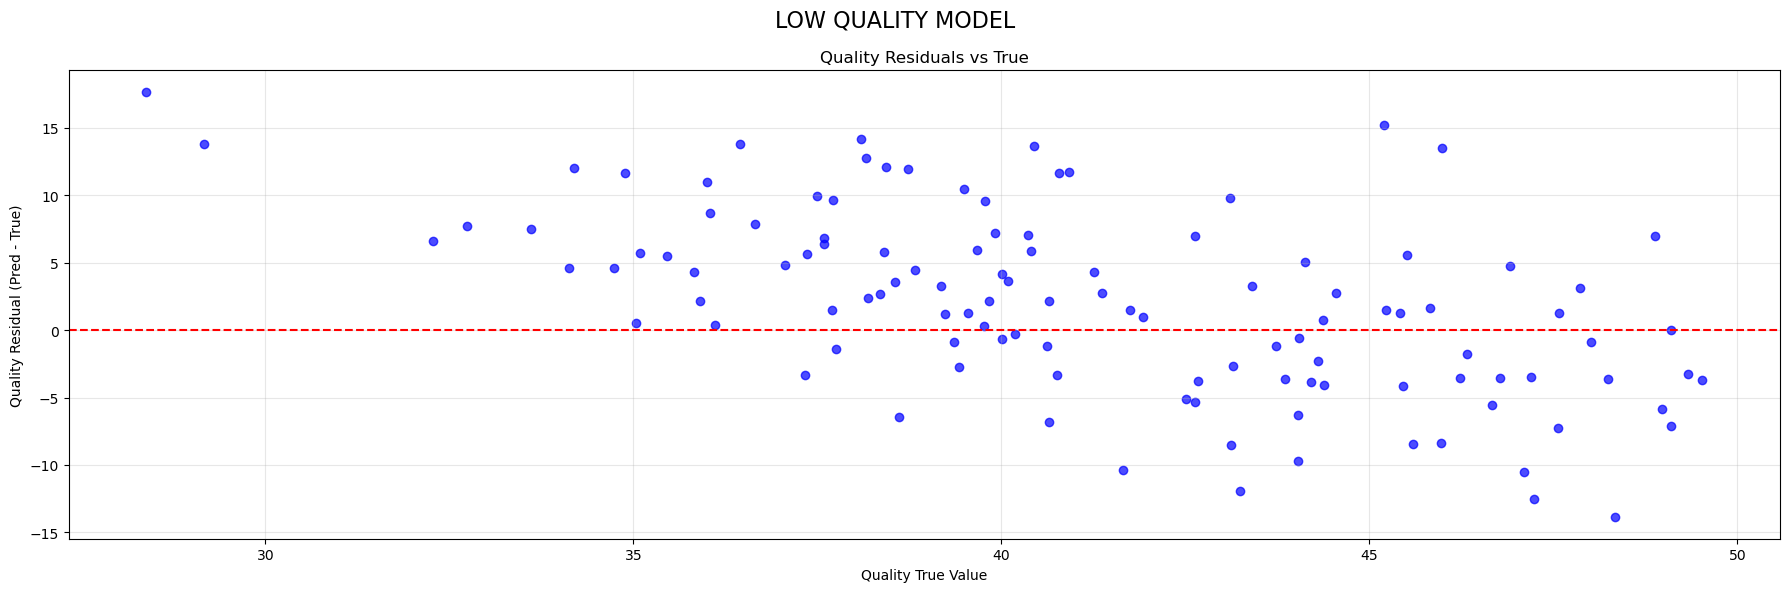

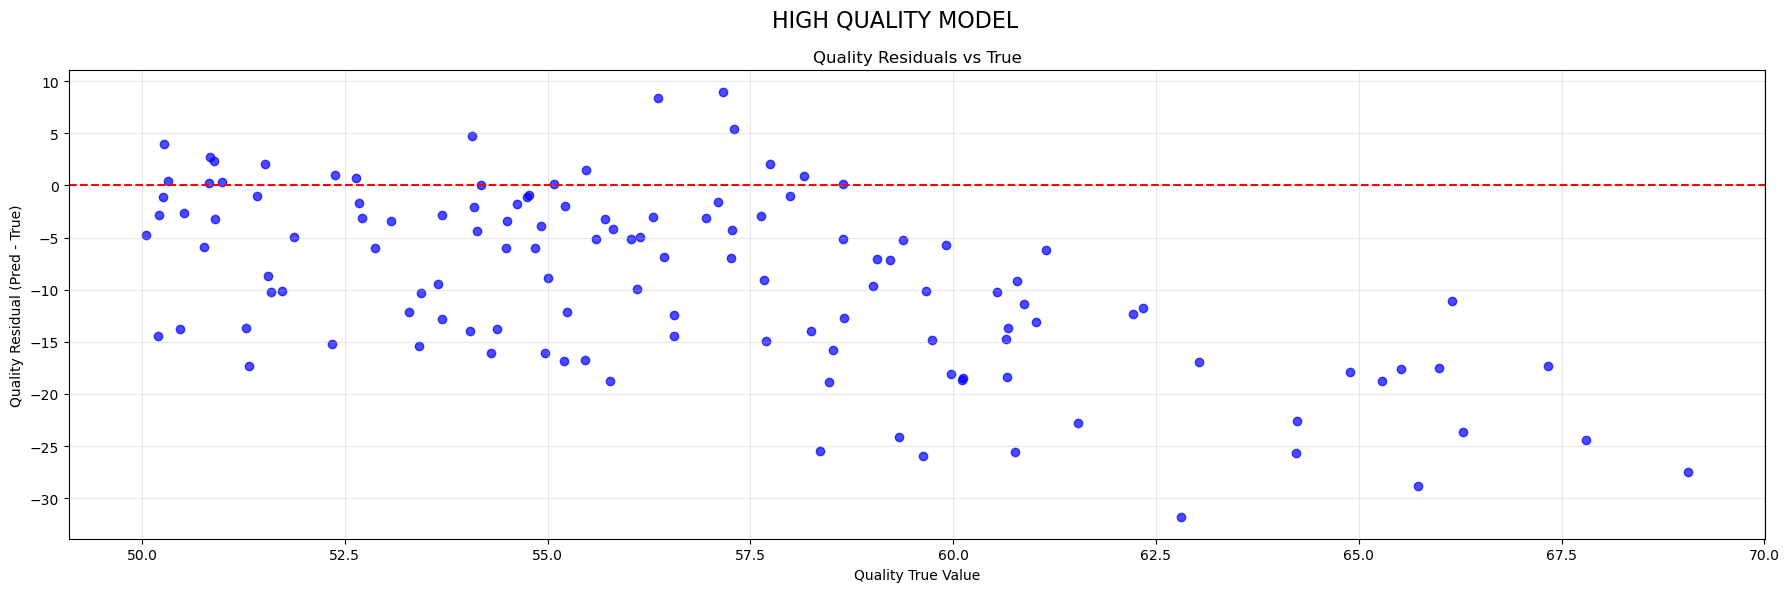

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.gridspec as gridspec


def compute_metrics(model, dataloader, device):
    """
    Computes metrics for model evaluation including residuals.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing predictions, ground truth, and calculated metrics
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Collect predictions and ground truth
    pred_list = []
    true_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            pred_list.append(outputs.cpu())
            true_list.append(labels)
    
    # Concatenate batches
    predictions = torch.cat(pred_list, dim=0).numpy()
    ground_truth = torch.cat(true_list, dim=0).numpy()
    
    # Extract quality and authenticity scores
    pred_quality = predictions
    true_quality = ground_truth
    
    # Calculate residuals (important for understanding distribution)
    quality_residuals = pred_quality - true_quality
    
    # Calculate correlation metrics for individual scores
    quality_spearman, q_pvalue = spearmanr(pred_quality, true_quality)
    
    # Calculate R² scores
    quality_r2 = r2_score(true_quality, pred_quality)
    
    
    # Calculate RMSE scores
    quality_rmse = np.sqrt(mean_squared_error(true_quality, pred_quality))
   
    # Create results dictionary
    results = {
        'predictions': {
            'quality': pred_quality,
        },
        'ground_truth': {
            'quality': true_quality,
        },
        'residuals': {
            'quality': quality_residuals,
        },
        'metrics': {
            'quality': {
                'spearman': quality_spearman,
                'p_value': q_pvalue,
                'r2': quality_r2,
                'rmse': quality_rmse
            }
        }
    }
    
    return results

def visualize_correlations(results, save_path=None, title=""):
    """
    Visualizes correlations and distributions from computed metrics.
    
    Args:
        results (dict): Results dictionary from compute_metrics function
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    # Extract data from results dictionary
    pred_quality = results['predictions']['quality']
    true_quality = results['ground_truth']['quality']
     
    quality_residuals = results['residuals']['quality']
    
    # Get metrics
    quality_metrics = results['metrics']['quality']
    
    # Create a larger figure with 3 rows and one column
    fig = plt.figure(figsize=(16, 18))
    fig.suptitle(title, fontsize=16)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    
    # Create subplots
    ax_quality = plt.Subplot(fig, gs[0])
    ax_quality_res = plt.Subplot(fig, gs[1])
    ax_quality_hist = plt.Subplot(fig, gs[2])

    
    # Function to plot correlation scatter plot
    def plot_correlation(ax, true_vals, pred_vals, metrics, title_suffix):
        ax.scatter(true_vals, pred_vals, alpha=0.7, color='blue')
        
        # Add identity line
        min_val = min(min(true_vals), min(pred_vals))
        max_val = max(max(true_vals), max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
        
        # Add regression line
        z = np.polyfit(true_vals, pred_vals, 1)
        p = np.poly1d(z)
        x_sorted = np.sort(true_vals)
        ax.plot(x_sorted, p(x_sorted), 'g-', label=f'Best fit (y = {z[0]:.3f}x + {z[1]:.3f})')
        
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'{title_suffix}\nSpearman ρ = {metrics["spearman"]:.4f}, R² = {metrics["r2"]:.4f}, RMSE = {metrics["rmse"]:.4f}')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left')
    
    # Function to plot residuals vs predicted
    def plot_residuals(ax, pred_vals, residuals, title_suffix):
        ax.scatter(pred_vals, residuals, alpha=0.7, color='orange')
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual (Pred - True)')
        ax.set_title(f'{title_suffix} Residuals vs Predicted')
        ax.grid(alpha=0.3)
    
    # Function to plot residual histogram
    def plot_residual_hist(ax, residuals, title_suffix):
        ax.hist(residuals, bins=20, alpha=0.7, color='green')
        ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlabel('Residual Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{title_suffix} Residual Distribution')
        # Add mean and std as text
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        ax.text(0.05, 0.95, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot all charts
    plot_correlation(ax_quality, true_quality, pred_quality, quality_metrics, 'Quality Score')
    plot_residuals(ax_quality_res, pred_quality, quality_residuals, 'Quality') 
    plot_residual_hist(ax_quality_hist, quality_residuals, 'Quality')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Print summary statistics
    print("-" * 50)
    print(f"MODEL EVALUATION: {title}")
    print("-" * 50)
    print(f"Quality Score - Spearman ρ: {quality_metrics['spearman']:.4f} (p-value: {quality_metrics['p_value']:.4g}), R²: {quality_metrics['r2']:.4f}, RMSE: {quality_metrics['rmse']:.4f}")

def plot_correlations(model, dataloader, device, save_path=None, title=""):
    """
    Wrapper function that computes metrics and visualizes correlations.
    Maintains backward compatibility with the original function.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
        
    Returns:
        dict: Dictionary containing correlation metrics
    """
    # Compute metrics
    results = compute_metrics(model, dataloader, device)
    
    # Visualize results
    visualize_correlations(results, save_path, title)
    
    # Return metrics for backward compatibility
    return results['metrics']

def true_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']
    
    # Create a figure with 1 subplot
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    ax.scatter(results['ground_truth']['quality'], quality_residuals, alpha=0.7, color='blue')
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Quality True Value')
    ax.set_ylabel('Quality Residual (Pred - True)')
    ax.set_title('Quality Residuals vs True')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

def pred_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']

    
    # Create a figure with 3 subplots
     # Create a figure with 1 subplot
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    ax.scatter(results['predictions']['quality'], quality_residuals, alpha=0.7, color='blue')
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Quality Predicted Value')
    ax.set_ylabel('Quality Residual (Pred - True)')
    ax.set_title('Quality Residuals vs Predicted')
    ax.grid(alpha=0.3)
    


    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()



LOW_QUALITY_PATH_NAME = 'Plots/low_quality_correlations.png'
HIGH_QUALITY_PATH_NAME = 'Plots/high_quality_correlations.png'

low_quality_results = compute_metrics(low_quality_predictor_trained, low_test_dataloader, device)
high_quality_results = compute_metrics(high_quality_predictor_trained, high_test_dataloader, device)

true_vs_error_plot(low_quality_results,save_path="Plots/baseline_true_vs_error.png", title="LOW QUALITY MODEL")
true_vs_error_plot(high_quality_results,save_path="Plots/baseline_true_vs_error.png", title="HIGH QUALITY MODEL")

low_q_results = compute_metrics(low_quality_predictor_trained, low_test_dataloader, device)
high_q_results = compute_metrics(high_quality_predictor_trained, high_test_dataloader, device)





In [21]:
print(low_q_results['metrics']['quality'])
print(high_q_results['metrics']['quality'])




{'spearman': np.float64(0.1332026294545035), 'p_value': np.float64(0.15402423850717833), 'r2': -1.389235258102417, 'rmse': np.float64(7.071198904207907)}
{'spearman': np.float64(-0.04247169103862018), 'p_value': np.float64(0.6367801921125837), 'r2': -6.843590259552002, 'rmse': np.float64(12.565898075091718)}
